In [3]:
import pandas as pd 
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,roc_curve ,auc
from imblearn.over_sampling import SMOTE
from geopy.distance import geodesic
import joblib

In [4]:
df=pd.read_csv('dataset.csv')
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [90]:
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])
df['hour']=df['trans_date_trans_time'].dt.hour
df['day']=df['trans_date_trans_time'].dt.day
df['month']=df['trans_date_trans_time'].dt.month
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,distance,hour,day,month
0,0,2019-01-01 00:00:18,2703186189652095,514,8,4.97,Jennifer,Banks,0,561 Perry Cove,...,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,78.773821,0,1,1
1,1,2019-01-01 00:00:44,630423337322,241,4,107.23,Stephanie,Gill,0,43039 Riley Greens Suite 393,...,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,30.216618,0,1,1
2,2,2019-01-01 00:00:51,38859492057661,390,0,220.11,Edward,Sanchez,1,594 White Dale Suite 530,...,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,108.102912,0,1,1
3,3,2019-01-01 00:01:16,3534093764340240,360,2,45.00,Jeremy,White,1,9443 Cynthia Court Apt. 038,...,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,95.685115,0,1,1
4,4,2019-01-01 00:03:06,375534208663984,297,9,41.96,Tyler,Garcia,1,408 Bradley Rest,...,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,77.702395,0,1,1


In [10]:
cat_col=['merchant','category','gender']
encoders={}
for col in cat_col:
    encoders[col]=LabelEncoder()
    df[col]=encoders[col].fit_transform(df[col])

In [11]:
def haversine(lat1, lon1, lat2, lon2):
   return np.array([geodesic((a,b), (c,d)).km for  a,b,c,d in zip(lat1, lon1, lat2, lon2)])
df['distance']=haversine(df['lat'], df['long'], df['merch_lat'], df['merch_long'])

In [12]:
# ensure datetime-derived columns exist before selecting features
if not {'hour', 'day', 'month'}.issubset(df.columns):
	df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
	df['hour'] = df['trans_date_trans_time'].dt.hour
	df['day'] = df['trans_date_trans_time'].dt.day
	df['month'] = df['trans_date_trans_time'].dt.month

features = ['merchant', 'category', 'amt', 'cc_num', 'hour', 'day', 'month', 'gender', 'distance']
x = df[features]
y = df['is_fraud']

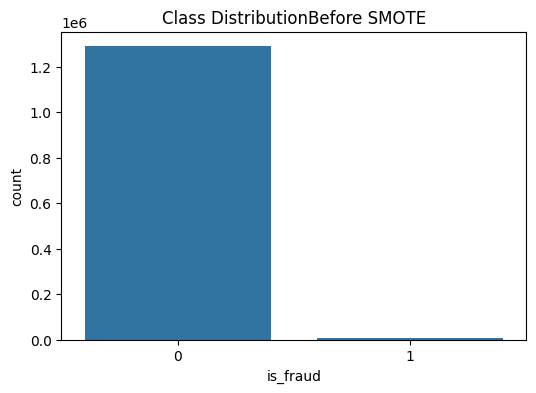

In [5]:
plt.figure(figsize=(6,4))
sns.countplot(x='is_fraud', data=df)
plt.title("Class DistributionBefore SMOTE")
plt.show()

In [13]:
smote=SMOTE(random_state=42)
x_res,y_res=smote.fit_resample(x,y)

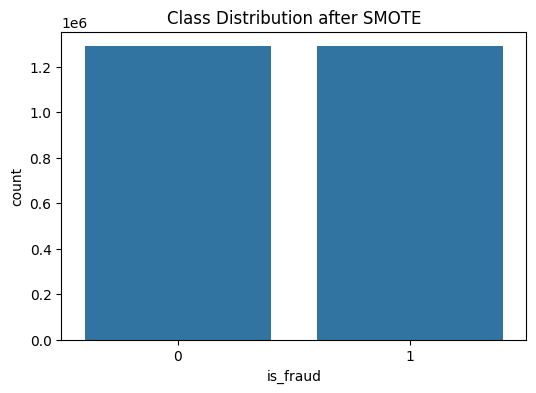

In [14]:
plt.figure(figsize=(6,4))
sns.countplot(x=y_res, data=df)
plt.title("Class Distribution after SMOTE")
plt.show()

In [15]:
x_train,x_test,y_train,y_test=train_test_split(x_res,y_res,test_size=0.2,random_state=42)

In [16]:
lgb_model=lgb.LGBMClassifier(
    boosting_type='gbdt',
    objective='binary',
    metric='auc',
    is_unbalance=True,
    learning_rate=0.05,
    num_leaves=31,
    n_estimators=100,
    max_depth=-1,
)
lgb_model.fit(x_train,y_train)


[LightGBM] [Info] Number of positive: 1030687, number of negative: 1031983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.171949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1105
[LightGBM] [Info] Number of data points in the train set: 2062670, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499686 -> initscore=-0.001257
[LightGBM] [Info] Start training from score -0.001257


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,100
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [17]:
y_pred=lgb_model.predict(x_test)

In [83]:
print("classification report:\n",classification_report(y_test,y_pred))
print("ROC AUC Score:",roc_auc_score(y_test,y_pred))

classification report:
               precision    recall  f1-score   support

           0       0.91      0.97      0.94    257186
           1       0.96      0.90      0.93    258482

    accuracy                           0.93    515668
   macro avg       0.94      0.93      0.93    515668
weighted avg       0.94      0.93      0.93    515668

ROC AUC Score: 0.9349871042263082


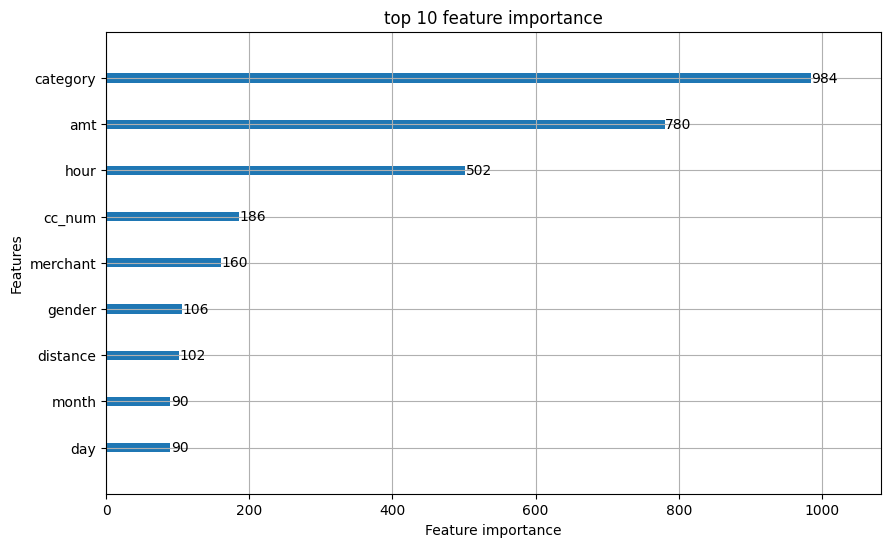

In [84]:
lgb.plot_importance(lgb_model,max_num_features=10,importance_type='split',figsize=(10,6))
plt.title("top 10 feature importance")
plt.show()

In [85]:
fpr,tpr,thresholds=roc_curve(y_test,lgb_model.predict_proba(x_test)[:,1])
roc_auc=auc(fpr,tpr)

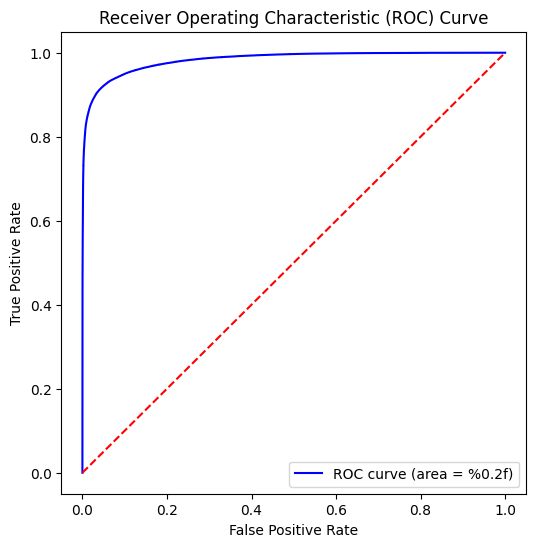

In [86]:
plt.figure(figsize=(6,6))
plt.plot(fpr,tpr,color='blue',label='ROC curve (area = %0.2f)' )
plt.plot([0,1],[0,1],color='red',linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [88]:
joblib.dump(lgb_model,'fraud_detection_model.jb')
joblib.dump(encoders,'label_encoders.jb')   

['label_encoders.jb']